In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import itertools
import random
import pandas as pd
import matplotlib 
from tqdm import tqdm

from scipy.stats import invwishart

matplotlib.rcParams['figure.figsize'] = (16, 16)

##### Generate data with normal distribution

In [2]:
params = [
            {"pi": 0.3, "mu": (2, 3), "covariance": [[2, 1], [1, 4]]},
            {"pi": 0.4, "mu": (8, 3), "covariance": [[3, 2], [2, 6]]},
            {"pi": 0.3, "mu": (5, 9), "covariance": [[1, 0], [0, 1]]},
        ]

In [3]:
total_toss = 1200
num_cluster = len(params)

In [4]:
def gen_data(num_cluster, total_toss):
    Z = [np.random.choice(num_cluster, 1, p=[params[i]['pi'] for i in range(num_cluster)])[0] for n_toss in range(total_toss)]
    data_dist = Counter(Z)
    data = {}
    for i in range(0, num_cluster):
        if data_dist[i] != 0: 
            data[i] = np.squeeze(np.random.multivariate_normal(params[i]["mu"], params[i]["covariance"], (1, data_dist[i])))
    return Z, data

In [5]:
actual_Z, data = gen_data(num_cluster, total_toss)

In [6]:
d = {k:v.tolist() for k, v in data.items()}
d_list = []
for k, v in d.items():
    for i in v:
        d_list.append([i[0], i[1], k])
dframe = pd.DataFrame(d_list, columns = ["X", "Y", "label"])

<AxesSubplot:xlabel='X', ylabel='Y'>

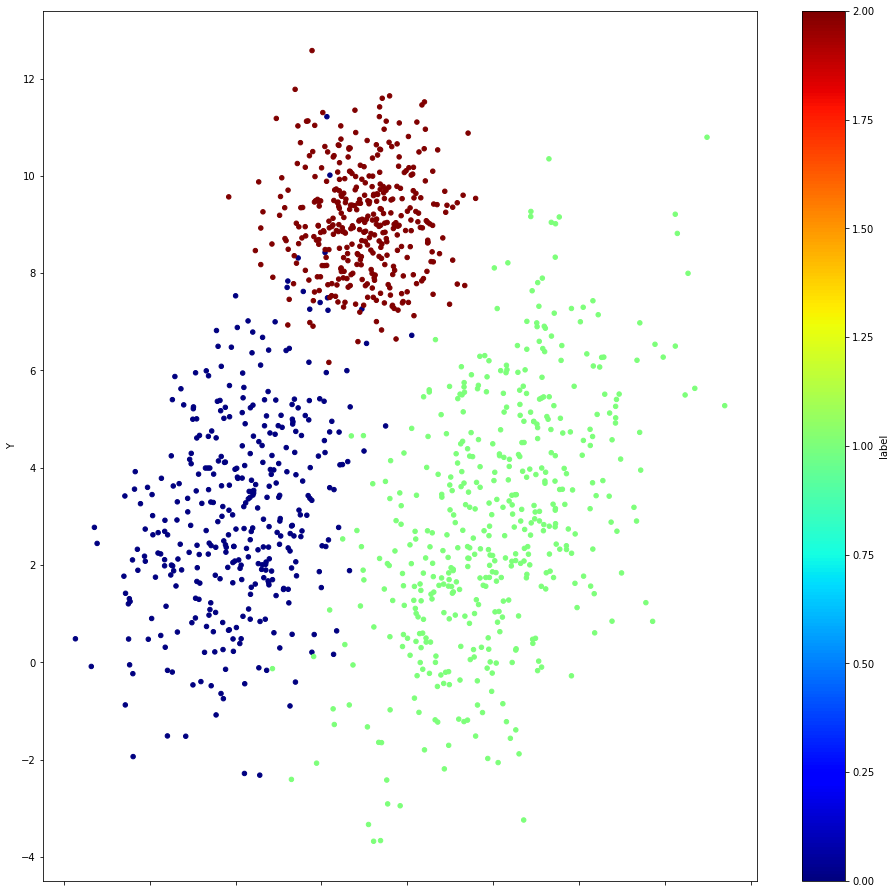

In [7]:
dframe.plot.scatter('X', 'Y', c='label', colormap='jet')

##### Generate labels 

In [8]:
Z = [np.random.choice(num_cluster, 1, p=[1/num_cluster for i in range(num_cluster)])[0] for n_toss in range(total_toss)]

In [9]:
data_list = []
for key, value in data.items():
    data_list.append(value.tolist())

In [10]:
data_list = list(itertools.chain(*data_list))

### Gaussian Prior

In [11]:
def gaussian_pdf(x_vector, mu_vector, covariance):
    # use case 
    # gaussian_pdf(np.array([3,2]), np.array([4,5]), np.array([[2,3], [3,2]]))
    D = len(x_vector)
    inv_covariance = np.linalg.inv(covariance)
    exp_term = np.exp(-0.5*np.dot(np.dot(np.transpose(x_vector-mu_vector),inv_covariance),(x_vector-mu_vector)))
    return (1/(2*np.pi)**D/2) * (1/np.abs(np.linalg.det(covariance))**0.5) * exp_term

##### UNKnown parameters 

In [12]:
# generate clusters by removing a data 
# gibbs sampling
def generate_cluster(X, data_i, Z, n_z):
    clusters = {}
    cluster_x = {}
    cluster_y = {}

    for k in range(0, n_z):
        clusters[k] = []
        cluster_x[k] = []
        cluster_y[k] = []
    
    for (x, z) in zip(X, Z):
        if (x == data_i).any():
            continue
        cluster_x[z].append(x[0])
        cluster_y[z].append(x[1])
    
    for k in range(len(cluster_x)):
        clusters[k] = np.vstack([cluster_x[k], cluster_y[k]]).T
        
    return clusters

In [13]:
def sample_mu_covariance(data, mu=np.array([0,0]), lmbda=1, nu=4, psi=np.eye(2)):
    n = len(data[:,0])
    mean_data = np.mean(data, axis=0)
    sum_squares = np.sum([np.array(np.matrix(x-mean_data).T * np.matrix(x-mean_data)) for x in data], axis = 0)
    mu_n = (lmbda * mu + n * mean_data) / (lmbda + n)
    lmbda_n = lmbda + n
    nu_n = nu + n
    psi_n = psi + sum_squares + lmbda * n / float(lmbda + n) * np.array(np.matrix(mean_data - mu).T * np.matrix(mean_data - mu))
    covariance = invwishart.rvs(nu_n, psi_n, size=1)
    
    # To compute mean
    x_bar = np.array([np.mean(data[:, 0]), np.mean(data[:,1])])
    A = ((lmbda * x_bar) +( nu_n * mu_n)) / (lmbda + nu_n)
    B = (1 / (lmbda + nu_n)) * covariance
    
    mean = np.random.multivariate_normal(A, B, size=1)[0]
    
    return mean, covariance 

In [14]:
def calculate_prob(X, x, Z, count, A, N):
    clusters = generate_cluster(X, x, Z, num_cluster)
    covariance = {}
    mean = {}
    # calculate mean and variance as the parameters are assumed to be unknown
    for k in clusters:
        mean[k], covariance[k] = sample_mu_covariance(np.array(clusters[k]))

    mu = []
    for k, v in mean.items():
        mu.append(v)
        
    final_prob = []
    norm_final_prob = []

    for k in range(num_cluster):
        k_prob = gaussian_pdf(x, mu[k], covariance[k])
        pr = ((count[k] + A/num_cluster)/(N + A - 1)) * k_prob

        final_prob.append(pr)

    sum_prob = sum(final_prob)
    for i in range(0, num_cluster):
        norm_final_prob.append(final_prob[i]/sum_prob)
        
    return norm_final_prob, final_prob

In [15]:
new_Z = [np.random.choice(num_cluster, 1, p=[1/num_cluster for i in range(num_cluster)])[0] for n_toss in range(total_toss)] 

data_numpy = [np.array(d) for d in data_list]

count = Counter(new_Z)
A = 0.1
N = len(data_numpy)

In [16]:
total_performance = []
total_iter = 30
for v in range(total_iter):
    performance = [] 

    for i, (x, z) in enumerate(zip(data_numpy, new_Z)):
        norm_final_prob, final_prob = calculate_prob(data_numpy, x, new_Z, count, A, N)
        new_Z[i] = (np.random.choice(num_cluster, 1, p=norm_final_prob)[0])
    
    
        performance.append(np.log(np.sum(final_prob)))
    total_performance.append(np.sum(performance))

### Compute maximum likelihood estimate 

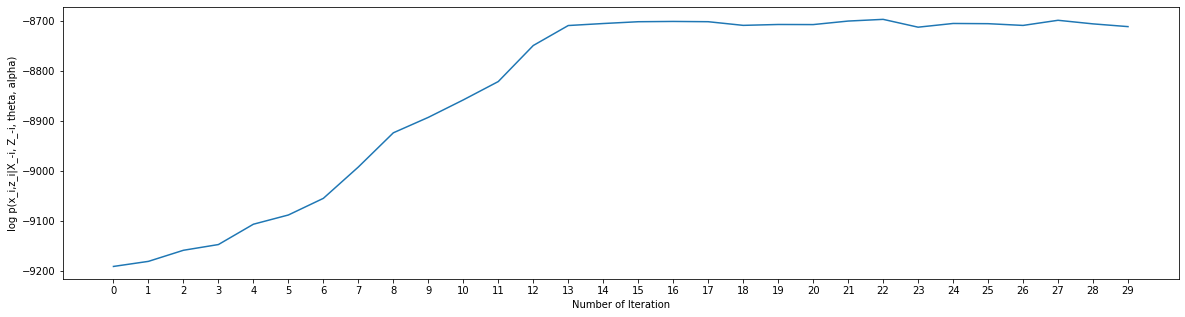

In [17]:
plt.figure(figsize=(20, 5))
plt.plot(total_performance)
plt.xlabel("Number of Iteration")
plt.ylabel("log p(x_i,z_i|X_-i, Z_-i, theta, alpha)")
plt.xticks([i for i in range(total_iter)])

plt.show()

In [18]:
df_list = []
for d, new_z, a_z in zip(data_list, new_Z, actual_Z):
    df_list.append([d[0], d[1], new_z, a_z])

In [19]:
frame = pd.DataFrame(df_list, columns = ["X", "Y", "model_label", "actual_label"])

<AxesSubplot:xlabel='X', ylabel='Y'>

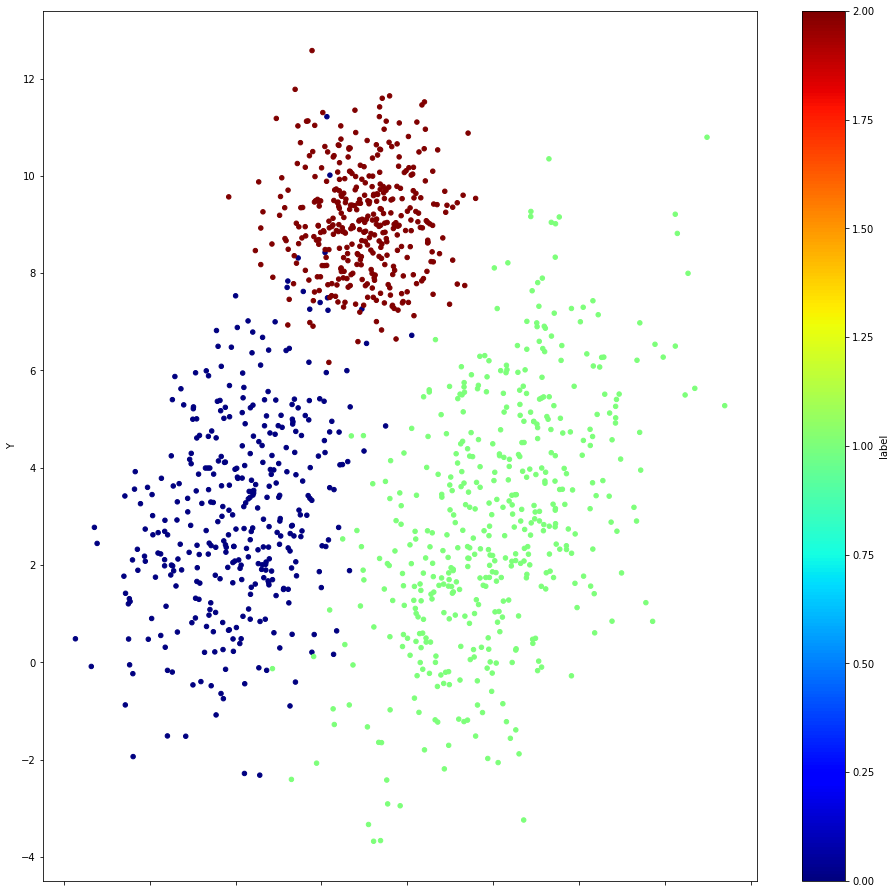

In [20]:
dframe.plot.scatter('X', 'Y', c='label', colormap='jet')

<AxesSubplot:xlabel='X', ylabel='Y'>

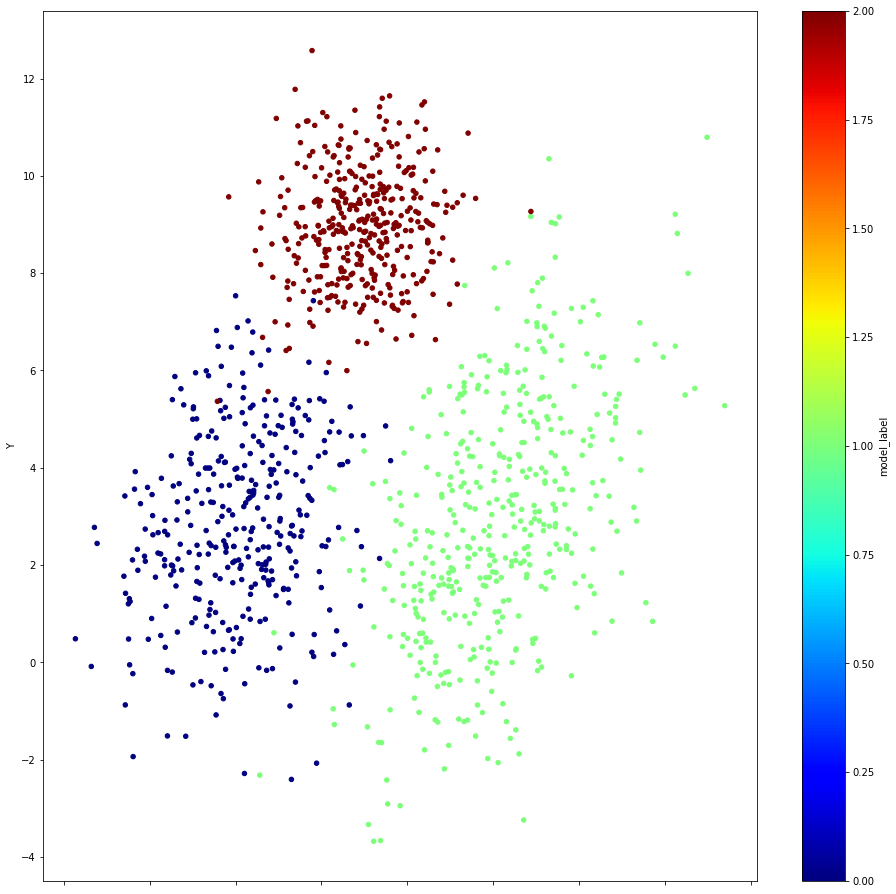

In [21]:
frame.plot.scatter('X', 'Y', c='model_label', colormap='jet')

In [22]:
model_params = []
for i, df in frame.groupby('model_label'):
    d = {}
    d['pi'] = len(df)/total_toss
    d['mu'] = (np.round(np.mean(df[["X"]].to_numpy().T),2), np.round(np.mean(frame[["Y"]].to_numpy().T),2))
    d['covariance'] = np.round(np.cov(df[["X", "Y"]].to_numpy().T), 2).tolist()
    model_params.append(d)

In [23]:
model_params

[{'pi': 0.29333333333333333,
  'mu': (2.08, 4.9),
  'covariance': [[1.84, 0.48], [0.48, 3.55]]},
 {'pi': 0.3775, 'mu': (8.11, 4.9), 'covariance': [[2.81, 2.08], [2.08, 6.47]]},
 {'pi': 0.32916666666666666,
  'mu': (4.93, 4.9),
  'covariance': [[1.12, 0.12], [0.12, 1.35]]}]

In [24]:
params

[{'pi': 0.3, 'mu': (2, 3), 'covariance': [[2, 1], [1, 4]]},
 {'pi': 0.4, 'mu': (8, 3), 'covariance': [[3, 2], [2, 6]]},
 {'pi': 0.3, 'mu': (5, 9), 'covariance': [[1, 0], [0, 1]]}]